In [7]:
pip install CPLEX


In [8]:
pip install docplex

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
from docplex.mp.model import Model
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [10]:
# Changes in Total Distance when changing the number of SDLs, their eligibility distance and the percentage of parcels delivered by car
results = []
SDL = (0, 1, 2, 3, 4, 5)
eligibility_distance = (15, 7, 3)

for sdl in SDL:
    print(f"\nResults for {sdl} SDLs:")
    for elig in eligibility_distance:
        i = 20
        I = ['c' + str(i) for i in range(1, i + 1)]
        f = sdl
        F = [f'f{f}' for f in range(1, f + 1)]
        Bf = 30
        si = {**{f'f{i}': 10 for i in range(1, f + 1)}, **{f'c{i}': 5 for i in range(1, 21)}}
        Ei = {**{f'c{i}': 420 for i in range(1, 11)}, **{f'c{i}': 600 for i in range(11, 21)}}
        Li = {**{f'c{i}': 480 for i in range(1, 11)}, **{f'c{i}': 660 for i in range(11, 21)}}
        N = F + I
        N0 = [0] + N
        i_j = {(i, j) for i in I for j in I if i != j}
        i_f = {(i, f) for i in I for f in F}
        i_j_N0 = {(i, j) for i in N0 for j in N0 if i != j} # to calculate distance
        tmax = 720
        compensation = 5
        vehicle_c = 1
        area_size = 10

        if sdl == 0:
            np.random.seed(42)  # Set seed for reproducibility
            loc_x = {'0': 0, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
            loc_y = {'0': 1, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
        elif sdl == 1:
            np.random.seed(42)
            loc_x = {'0': 0, 'f1': 3, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
            loc_y = {'0': 1, 'f1': 3, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
        elif sdl == 2:
            np.random.seed(42)
            loc_x = {'0': 0, 'f1': 3, 'f2': 7, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
            loc_y = {'0': 1, 'f1': 3, 'f2': 7, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
        elif sdl == 3:
            np.random.seed(42)
            loc_x = {'0': 0, 'f1': 3, 'f2': 7, 'f3': 3, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
            loc_y = {'0': 1, 'f1': 3, 'f2': 7, 'f3': 7, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
        elif sdl == 4:
            np.random.seed(42)
            loc_x = {'0': 0, 'f1': 3, 'f2': 7, 'f3': 3, 'f4': 7, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
            loc_y = {'0': 1, 'f1': 3, 'f2': 7, 'f3': 7, 'f4': 3, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
        elif sdl == 5:
            np.random.seed(42)
            loc_x = {'0': 0, 'f1': 3, 'f2': 7, 'f3': 3, 'f4': 7, 'f5': 5, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}
            loc_y = {'0': 1, 'f1': 3, 'f2': 7, 'f3': 7, 'f4': 3, 'f5': 5, **{f'c{i}': np.random.rand(1) * area_size for i in range(1, 21)}}

        distance = {(i, j): np.hypot(loc_x[str(i)] - loc_x[str(j)], loc_y[str(i)] - loc_y[str(j)]) for i, j in i_j_N0}
        Vi = {i: [f for f in F if distance[(i, f)] < elig] for i in I}
        c = {(i, j): int((np.hypot(loc_x[str(i)] - loc_x[str(j)], loc_y[str(i)] - loc_y[str(j)])) * 3) for i, j in i_j_N0}
        t = c
        T_init = 5

        # Decision variables
        mdl = Model('CVRP')
        x = mdl.binary_var_dict(i_j_N0, name='x')
        y = mdl.binary_var_dict(i_f, name='y')
        z = mdl.binary_var_dict(F, name='z')
        T = mdl.continuous_var_dict(N0, name='T')

        # Objective function
        mdl.minimize(mdl.sum(c[i, j] * x[i, j] for i, j in i_j_N0) +
                     compensation * mdl.sum(y[i, f] for i, f in i_f) +
                     vehicle_c * mdl.sum(x[0, j] for j in N))

        # Constraints
        # Customer-Carrier Assignment Constraint
        for i in I:
            mdl.add_constraint(mdl.sum(x[i, j] for j in N0 if i != j) +
                               mdl.sum(y[i, f] for f in F) == 1)

        # Symmetry Constraint
        for j in N0:
            mdl.add_constraint(mdl.sum(x[i, j] for i, j in i_j_N0) ==
                               mdl.sum(x[j, i] for j, i in i_j_N0))

        # SDL Constraint
        for f in F:
            mdl.add_constraint(z[f] >= 1 / len(I) * mdl.sum(y[i, f] for i in I))

        # SDL Load Constraint
        for f in F:
            mdl.add_constraint(mdl.sum(x[i, j] for i, j in i_j_N0 if j == f and (i, f) in i_f) == z[f])

        # Time Window Constraint
        for j in N:
            for i in N0:
                if i != j:
                    mdl.add_constraint(T[j] >= T[i] + t[i, j] + si[j] - 2 * tmax * (1 - x[i, j]))

        for j in N:
            mdl.add_constraint(T[j] <= tmax * mdl.sum(x[i, j] for i in N0 if i != j))

        # Time Window Bounds Constraint
        for i in I:
            mdl.add_constraint(Ei[i] - tmax * mdl.sum(y[i, f] for f in F) <= T[i])
            mdl.add_constraint(T[i] <= Li[i] + tmax * mdl.sum(y[i, f] for f in F))

        # Time Limit Constraint
        for j in N:
            mdl.add_constraint(T[j] + si[j] + t[0, j] <= tmax)

        # SDL Capacity Constraint
        for f in F:
            mdl.add_constraint(mdl.sum(y[i, f] for i in I) <= Bf)

        # Unused SDL Constraint
        for i in I:
            for f in F:
                if f not in Vi[i]:
                    mdl.add_constraint(y[i, f] == 0)

        mdl.solve()
        total_distance = sum(c[i, j] * x[i, j].solution_value for i, j in i_j_N0 if x[i, j].solution_value > 0.5)

        print(f" Results for eligibility distance {elig} km:")

        # Changes in Total Distance when changing the percentage of parcels delivered by car
        percentage = (1, 0.75, 0.5, 0.25, 0)
        for p in percentage:
            # Filter pairs where y[i, f].solution_value == 1
            selected_pairs = [(i, f) for i, f in i_f if y[i, f].solution_value == 1]

            # Calculate the number of pairs to select based on the percentage
            num_pairs_to_select = int(len(selected_pairs) * p)

            # Randomly select the required number of pairs
            random.shuffle(selected_pairs)
            selected_pairs = selected_pairs[:num_pairs_to_select]

            # Sum up the distances for the selected pairs
            pickup_distance = sum(distance[i, f] for i, f in selected_pairs)
            total_distance_with_pickup = total_distance + pickup_distance

            print(f"   Results for {p*100}% percentage:")
            print(f"    Pickup Distance: {round(float(pickup_distance), 1)}, Total Distance Including Pickups: {round(float(total_distance_with_pickup), 1)}")
            # Store the results in the list as a dictionary
            results.append({
                'no._of_sdls': sdl,
                'eligibility_distance': elig,
                'car_percentage': p * 100,
                'pickup_distance': round(float(pickup_distance), 1),
                'total_distance': round(float(total_distance_with_pickup), 1)
            })


Results for 0 SDLs:
 Results for eligibility distance 15 km:
   Results for 100% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 75.0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 50.0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 25.0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
 Results for eligibility distance 7 km:
   Results for 100% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 75.0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 50.0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results for 25.0% percentage:
    Pickup Distance: 0.0, Total Distance Including Pickups: 156.0
   Results f

In [11]:
# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('results.csv', index=False)

    no._of_sdls  eligibility_distance  car_percentage  pickup_distance  \
0             0                    15           100.0              0.0   
1             0                    15            75.0              0.0   
2             0                    15            50.0              0.0   
3             0                    15            25.0              0.0   
4             0                    15             0.0              0.0   
..          ...                   ...             ...              ...   
85            5                     3           100.0             24.0   
86            5                     3            75.0             15.7   
87            5                     3            50.0             11.1   
88            5                     3            25.0              5.5   
89            5                     3             0.0              0.0   

    total_distance  
0            156.0  
1            156.0  
2            156.0  
3            156.0  
4     

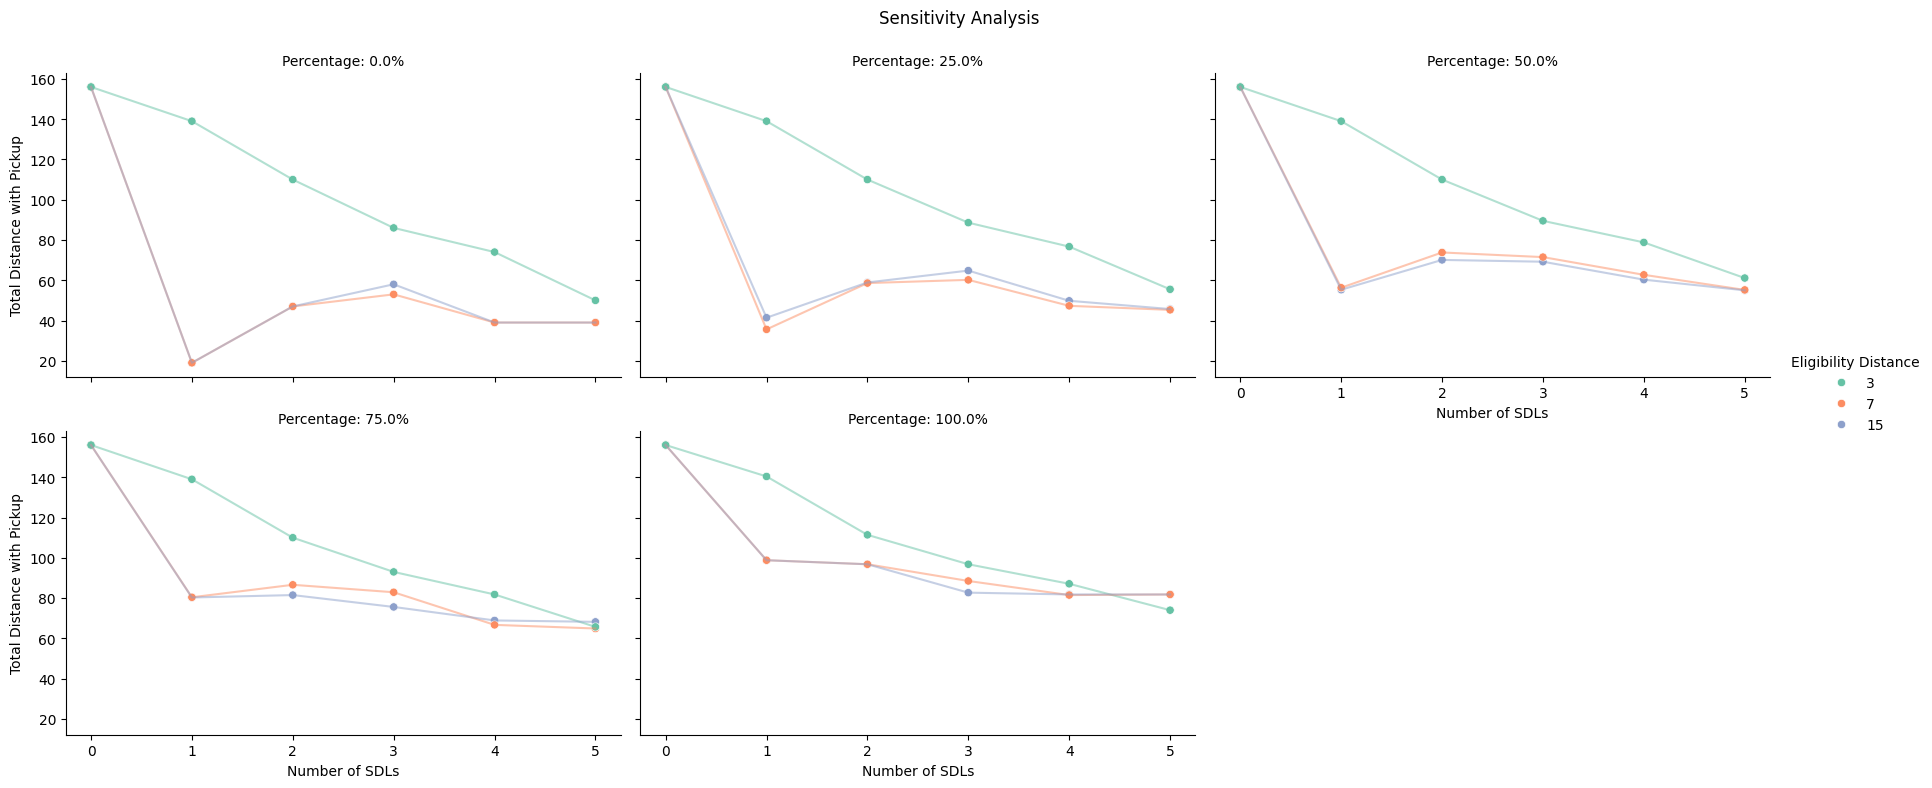

In [21]:
g = sns.FacetGrid(df, col='car_percentage', col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'no._of_sdls', 'total_distance', 'eligibility_distance', palette='Set2',alpha=0.5)
g.map(sns.scatterplot, 'no._of_sdls', 'total_distance', 'eligibility_distance', palette='Set2')
g.add_legend(title='Eligibility Distance')
g.set_axis_labels('Number of SDLs', 'Total Distance with Pickup')
g.set_titles(col_template='Percentage: {col_name}%')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sensitivity Analysis')
plt.show()